Contour plot of ln(evidence) for loss against number of layers\
for limited and not limited thickness

ploting ln(evidence) for changes in $Dq/q$ vs $\lambda$, with $\lambda$ scaleing dR

In [1]:
import os.path
import numpy as np
import matplotlib.pyplot as plt
import scipy
import refnx
from refnx.dataset import ReflectDataset, Data1D
from refnx.analysis import Transform, CurveFitter, Objective, Model, Parameter
from refnx.reflect import SLD, Slab, ReflectModel
from sepObjective import getObjective as gO
from dynesty import DynamicNestedSampler
from dynesty import plotting as dyplot
from CFitter import CFitter
import make_sim_data as msd
print('refnx: %s\nscipy: %s\nnumpy: %s' % (refnx.version.version,
                   scipy.version.version, np.version.version))


refnx: 0.1.9
scipy: 1.3.0
numpy: 1.16.4
refnx: 0.1.9
scipy: 1.3.0
numpy: 1.16.4


In [2]:
def aPlotter(res, interestingNo, spacesize, figI):
    print(figI)
    # no = -1000
    # slc = slice(no-1000,no)
    useAbleLow=0.1
    useAbleHigh=10.
    xall=np.linspace(0,spacesize,len(res["logz"]))
    print("len",len(res["logz"]), "space size", spacesize)
    useable=np.transpose(np.array([[x,y] for y,x in zip(res["logz"],xall) if np.exp(y)>useAbleLow and np.exp(y)<=useAbleHigh]))
    # print(len(res["logz"]),res["logz"][slc])#summary()
    interesting = np.transpose(np.array([[x,y] for y,x in zip(res["logz"],xall) if x>=float(interestingNo)]))#.reshape((2,-2))
    print("len 2", len(interesting[0]), len(interesting), interesting[0,:3])
    print("logz max: ",max(res["logz"]),",min: ",min(res["logz"]))
    print("z max: ",max(np.exp(res["logz"])),",min: ",min(np.exp(res["logz"])))
#     print(res["logz"][:5],interesting[1,:5],useable[1,:5])
    # print("interesting")
#     xall=np.linspace(0,spacesize,len(res["logz"]))
#     xusable=np.linspace(0,spacesize,len(useable))
    plt.figure(figI)
    figI+=1
    plt.plot(xall,res["logz"])
    plt.title("ln(evidence) log scaled vs -ln(X)")
    # plt.yscale("log")
    plt.figure(figI)
    figI+=1
    plt.plot(interesting[0],interesting[1])
    plt.title(r"interesting values ln(evidence)  vs -ln(X) $\geq %d$" % interestingNo)
    if len(useable)>=2:
        plt.figure(figI)
        figI+=1
        plt.plot(useable[0],useable[1])
        plt.title(r"usful values ln(%.3f<evidence $\leq$ %.3f)  vs -ln(X)"%(useAbleLow,useAbleHigh))
    print(figI)
    return figI

In [3]:
figI = 0
# simple structure
thicks_true = [10,120,100,130,10]
bs_true = [0,5,4.5,5,10]
roughs_true = [0,0,0,0,0]
# bs = [5,4.5,5]
# thicks = [120,100,130]
# roughs = [0,0,0]
bs = bs_true
thicks = thicks_true
roughs = roughs_true
loss = 1.
no_layers = len(bs)
no_layers = len(bs_true)
# no_layers = 3
layers = []
names = []
#names = ['layer1','layer2']
for i in range(no_layers):
    names.append('layer'+str(i))
for i in range(no_layers):
        sld = SLD(bs[i],name=names[i])
        layers.append(sld(thicks[i],roughs[i]))
structure = layers[0]
for layer in layers[1:]:
    structure|=layer
print("done")

done


done


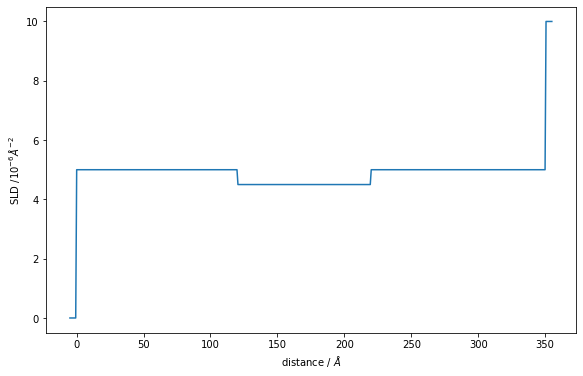

In [4]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [9.5, 6]
#notebook
plt.figure(figI)
figI+=1
plt.plot(*structure.sld_profile())
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$');
print("done")

In [5]:
resolution = 5.
model = ReflectModel(structure, bkg=3e-6, dq=resolution)

csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]


<ErrorbarContainer object of 3 artists>

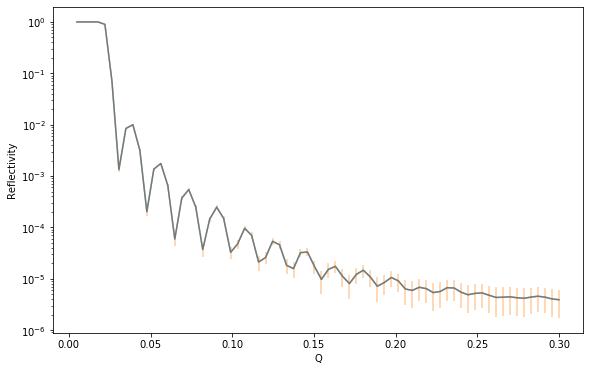

In [6]:
q = np.linspace(0.005, 0.3, 70)
plt.figure(figI)
figI+=1
R = model(q, x_err=resolution)
plt.plot(q, R)
plt.xlabel('Q')
plt.ylabel('Reflectivity')
plt.yscale('log')
#Q, R(Q), sig_Q, sig_R =
import make_sim_data as msd
sim_dR = msd.main(sim_q=q,sim_R=R)*10
R = model(q, x_err=resolution)
plt.errorbar(q,R,sim_dR, alpha=0.4)

In [7]:
data = Data1D(data= (q,R,sim_dR))

In [ ]:
maxLength = 350
def logp_extra(model, data=None):
    returns = 0
    if sum(model.structure.slabs()[1:-1,0])>maxLength:
        returns = -np.inf
    return returns

In [9]:
resolutions = [1.,3.,7.,9.]
dRScaleBys = [5,10,15,20]
# lnPosts = []
# lnPostss = []
lnEvidence1 = []
lnEvidence2 = []
figI=1
# resolution = 5.
for dRScaleBy in dRScaleBys:
#     datas=[]
    for resolution in resolutions:
        model = ReflectModel(structure, bkg=3e-6, dq=resolution)
        q = np.linspace(0.005, 0.3, 70)# was 1001
#         plt.figure(figI)
        R = model(q, x_err=resolution)
#         plt.plot(q, R)
#         plt.xlabel('Q')
#         plt.ylabel('Reflectivity')
#         plt.yscale('log')
#         plt.title('dR scaled by '+str(dRScaleBy)+' dq '+str(resolution))
        #Q, R(Q), sig_Q, sig_R =
        sim_dR = msd.main(sim_q=q,sim_R=R)*dRScaleBy
#         R = model(q, x_err=resolution)
#         plt.errorbar(q,R,sim_dR, alpha=0.4)
        data = Data1D(data= (q,R,sim_dR))
        print("dRScaleBy:",dRScaleBy,"resolution:",resolution)

        objective = gO(data, 3, logpExtra=logp_extra)
        fitter = CFitter(objective)
        DNSampler = DynamicNestedSampler(fitter.logl, fitter.priorTransform, fitter.nDim()) #1:01:10 or 28:46 time
        DNSampler.run_nested(dlogz_init=0.05)# was 0.01
        result = DNSampler.results
        lnEvidence = result["logz"][-1]
        print("thickness limited lnEvidence:",lnEvidence)
        lnEvidence1.append(lnEvidence)

        objective = gO(data, 3)
        fitter = CFitter(objective)
        DNSampler = DynamicNestedSampler(fitter.logl, fitter.priorTransform, fitter.nDim()) #1:01:10 or 28:46 time
        DNSampler.run_nested(dlogz_init=0.05)# was 0.01
        result = DNSampler.results
        lnEvidence = result["logz"][-1]
        print("lnEvidence:",lnEvidence)
        lnEvidence2.append(lnEvidence)
#         print(lnPost)
#         lnPosts.append(lnPost)

csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]
dRScaleBy: 5 resolution: 1.0


28784it [07:29, 64.02it/s, batch: 8 | bound: 152 | nc: 5 | ncall: 139213 | eff(%): 20.676 | loglstar: -870.196 < -862.024 < -864.038 | logz: -886.259 +/-  0.283 | stop:  0.950]        


thickness limited lnEvidence: -886.2338759719516


34433it [08:30, 67.48it/s, batch: 8 | bound: 198 | nc: 1 | ncall: 173773 | eff(%): 19.815 | loglstar: -870.312 < -861.714 < -861.770 | logz: -886.373 +/-  0.284 | stop:  0.913]        


lnEvidence: -886.3654858783067
csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]
dRScaleBy: 5 resolution: 3.0


34441it [07:39, 74.97it/s, batch: 9 | bound: 162 | nc: 1 | ncall: 144239 | eff(%): 23.878 | loglstar: -243.503 < -235.189 < -235.213 | logz: -256.814 +/-  0.266 | stop:  0.938]         


thickness limited lnEvidence: -256.8224918348395


24240it [05:21, 75.37it/s, batch: 7 | bound: 108 | nc: 1 | ncall: 101282 | eff(%): 23.933 | loglstar: -242.707 < -235.286 < -236.421 | logz: -256.919 +/-  0.267 | stop:  0.991]        


lnEvidence: -256.92328393233277
csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]
dRScaleBy: 5 resolution: 7.0


31835it [29:28, 18.00it/s, batch: 7 | bound: 824 | nc: 9 | ncall: 706064 | eff(%):  4.509 | loglstar: -42.966 < -34.386 < -34.541 | logz: -61.058 +/-  0.296 | stop:  0.952]            


thickness limited lnEvidence: -61.03303894872692


35760it [17:50, 33.41it/s, batch: 8 | bound: 434 | nc: 1 | ncall: 399367 | eff(%):  8.954 | loglstar: -43.771 < -34.734 < -36.504 | logz: -61.037 +/-  0.291 | stop:  0.958]             


lnEvidence: -61.02068196011918
csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]
dRScaleBy: 5 resolution: 9.0


34298it [08:28, 67.51it/s, batch: 7 | bound: 161 | nc: 1 | ncall: 140830 | eff(%): 24.354 | loglstar: -661.480 < -652.960 < -653.058 | logz: -682.628 +/-  0.315 | stop:  0.983]        


thickness limited lnEvidence: -682.6266779760213


33794it [5:48:20,  1.62it/s, batch: 7 | bound: 12171 | nc: 3 | ncall: 9185455 | eff(%):  0.368 | loglstar: -661.692 < -652.968 < -653.088 | logz: -681.481 +/-  0.308 | stop:  0.933]             


lnEvidence: -681.4610409074794
csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]
dRScaleBy: 10 resolution: 1.0


30693it [09:04, 56.36it/s, batch: 8 | bound: 163 | nc: 1 | ncall: 148717 | eff(%): 20.639 | loglstar: -161.824 < -153.213 < -153.366 | logz: -173.079 +/-  0.248 | stop:  0.940]      


thickness limited lnEvidence: -173.0746737843894


31918it [09:20, 56.96it/s, batch: 8 | bound: 167 | nc: 5 | ncall: 152462 | eff(%): 20.935 | loglstar: -161.783 < -153.202 < -153.265 | logz: -173.092 +/-  0.248 | stop:  0.906]      


lnEvidence: -173.05969495127744
csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]
dRScaleBy: 10 resolution: 3.0


22095it [06:35, 55.90it/s, batch: 7 | bound: 104 | nc: 7 | ncall: 104977 | eff(%): 21.047 | loglstar: -0.245 <  7.208 <  5.190 | logz: -10.291 +/-  0.236 | stop:  0.930]             


thickness limited lnEvidence: -10.302971524391873


22171it [06:55, 53.41it/s, batch: 7 | bound: 103 | nc: 2 | ncall: 107125 | eff(%): 20.696 | loglstar: -0.372 <  7.151 <  5.305 | logz: -10.496 +/-  0.236 | stop:  0.922]             


lnEvidence: -10.485837192186086
csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]
dRScaleBy: 10 resolution: 7.0


25065it [1:02:28,  6.69it/s, batch: 7 | bound: 1754 | nc: 6050 | ncall: 1709800 | eff(%):  1.466 | loglstar: 53.761 < 61.808 < 60.042 | logz: 40.872 +/-  0.256 | stop:  0.895]       


thickness limited lnEvidence: 40.878851270732426


33061it [58:14,  9.46it/s, batch: 8 | bound: 1620 | nc: 34 | ncall: 1466949 | eff(%):  2.254 | loglstar: 53.408 < 62.266 < 62.151 | logz: 40.792 +/-  0.256 | stop:  0.843]           


lnEvidence: 40.75223150230152
csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]
dRScaleBy: 10 resolution: 9.0


30570it [54:15,  9.39it/s, batch: 7 | bound: 1669 | nc: 1 | ncall: 1299662 | eff(%):  2.352 | loglstar: -101.872 < -91.391 < -91.635 | logz: -114.423 +/-  0.262 | stop:  0.987]         


thickness limited lnEvidence: -114.4072512583621


31411it [1:57:23,  4.46it/s, batch: 6 | bound: 3622 | nc: 2 | ncall: 2954587 | eff(%):  1.063 | loglstar: -101.996 < -91.372 < -91.538 | logz: -114.714 +/-  0.264 | stop:  0.862]       


lnEvidence: -114.68229572753494
csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]
dRScaleBy: 15 resolution: 1.0


22614it [05:44, 65.59it/s, batch: 7 | bound: 119 | nc: 3 | ncall: 118245 | eff(%): 19.125 | loglstar: -49.810 < -41.638 < -43.462 | logz: -58.694 +/-  0.226 | stop:  0.826]         


thickness limited lnEvidence: -58.64780510695973


29739it [07:10, 69.09it/s, batch: 8 | bound: 161 | nc: 7 | ncall: 148458 | eff(%): 20.032 | loglstar: -50.222 < -41.401 < -41.499 | logz: -58.442 +/-  0.224 | stop:  0.933]         


lnEvidence: -58.44818983219997
csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]
dRScaleBy: 15 resolution: 3.0


27774it [06:47, 68.20it/s, batch: 8 | bound: 141 | nc: 2 | ncall: 140228 | eff(%): 19.806 | loglstar: 24.716 < 32.881 < 32.801 | logz: 17.455 +/-  0.214 | stop:  0.976]             


thickness limited lnEvidence: 17.468412975171937


29057it [06:50, 70.71it/s, batch: 8 | bound: 147 | nc: 21 | ncall: 141720 | eff(%): 20.503 | loglstar: 24.575 < 32.887 < 32.837 | logz: 17.368 +/-  0.216 | stop:  0.992]             


lnEvidence: 17.37091701476931
csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]
dRScaleBy: 15 resolution: 7.0


31415it [1:09:14,  7.56it/s, batch: 7 | bound: 2126 | nc: 1 | ncall: 1906051 | eff(%):  1.648 | loglstar: 50.264 < 60.753 < 60.577 | logz: 42.357 +/-  0.222 | stop:  0.790]         


thickness limited lnEvidence: 42.341773042336406


26237it [41:56, 10.43it/s, batch: 7 | bound: 1203 | nc: 12 | ncall: 1086113 | eff(%):  2.416 | loglstar: 50.316 < 60.384 < 58.180 | logz: 42.456 +/-  0.220 | stop:  0.895]          


lnEvidence: 42.5108219989175
csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]
dRScaleBy: 15 resolution: 9.0


30836it [1:24:53,  6.05it/s, batch: 8 | bound: 3107 | nc: 4 | ncall: 2376460 | eff(%):  1.298 | loglstar: -16.564 < -7.371 < -10.466 | logz: -26.086 +/-  0.232 | stop:  0.993]            


thickness limited lnEvidence: -26.07731100106868


21616it [05:06, 70.45it/s, batch: 7 | bound: 85 | nc: 7 | ncall: 86150 | eff(%): 25.091 | loglstar: -15.954 < -6.949 < -9.950 | logz: -26.815 +/-  0.244 | stop:  0.824]             


lnEvidence: -26.765799975725457
csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]
dRScaleBy: 20 resolution: 1.0


26181it [06:34, 66.32it/s, batch: 8 | bound: 142 | nc: 9 | ncall: 137694 | eff(%): 19.014 | loglstar: -21.362 < -12.494 < -12.636 | logz: -27.733 +/-  0.208 | stop:  0.976]        


thickness limited lnEvidence: -27.701438332130166


23010it [05:57, 64.43it/s, batch: 8 | bound: 125 | nc: 2 | ncall: 120718 | eff(%): 19.061 | loglstar: -21.184 < -12.769 < -14.396 | logz: -27.849 +/-  0.209 | stop:  0.904]        


lnEvidence: -27.847024452945774
csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]
dRScaleBy: 20 resolution: 3.0


28040it [06:49, 68.50it/s, batch: 8 | bound: 150 | nc: 6 | ncall: 139439 | eff(%): 20.109 | loglstar: 23.184 < 31.613 < 31.556 | logz: 17.906 +/-  0.197 | stop:  0.899]           


thickness limited lnEvidence: 17.923427521647163


25504it [06:44, 63.11it/s, batch: 9 | bound: 134 | nc: 3 | ncall: 127247 | eff(%): 20.043 | loglstar: 23.063 < 31.486 < 30.396 | logz: 17.806 +/-  0.198 | stop:  0.908]            


lnEvidence: 17.7413881949897
csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]
dRScaleBy: 20 resolution: 7.0


29782it [36:56, 13.44it/s, batch: 7 | bound: 1135 | nc: 2 | ncall: 976764 | eff(%):  3.049 | loglstar: 38.664 < 50.007 < 49.837 | logz: 34.362 +/-  0.193 | stop:  0.859]            


thickness limited lnEvidence: 34.37910322948846


28629it [25:50, 18.46it/s, batch: 7 | bound: 738 | nc: 1 | ncall: 660722 | eff(%):  4.333 | loglstar: 38.730 < 48.828 < 46.248 | logz: 34.542 +/-  0.184 | stop:  0.950]             


lnEvidence: 34.524598968004895
csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]
dRScaleBy: 20 resolution: 9.0


21991it [05:09, 71.00it/s, batch: 7 | bound: 91 | nc: 3 | ncall: 90629 | eff(%): 24.265 | loglstar:  4.092 < 11.739 < 10.137 | logz: -4.690 +/-  0.223 | stop:  0.915]              


thickness limited lnEvidence: -4.680316380923956


21417it [05:12, 68.57it/s, batch: 7 | bound: 93 | nc: 9 | ncall: 92226 | eff(%): 23.222 | loglstar:  4.238 < 11.777 <  9.966 | logz: -4.473 +/-  0.221 | stop:  0.958]              


lnEvidence: -4.491294767664335


In [11]:
f=open("dDqDR2Dupdated.txt","w+")
f.write("limited max thickness ln(evidence):\n")
for lnEvidence in lnEvidence1:
    f.write(str(lnEvidence)+"\n")
f.write("\nnot limited max thickness ln(evidence):\n")
for lnEvidence in lnEvidence2:
    f.write(str(lnEvidence)+"\n")
f.close()

26499it [24:55, 17.72it/s, batch: 7 | bound: 706 | nc: 8 | ncall: 646207 | eff(%):  4.101 | loglstar: -202.191 < -195.105 < -197.037 | logz: -220.134 +/-  0.292 | stop:  0.952]         
-220.11328681456592

28379it [08:30, 55.62it/s, batch: 8 | bound: 181 | nc: 6 | ncall: 161880 | eff(%): 17.531 | loglstar: 1000.415 < 1008.232 < 1007.220 | logz: 982.787 +/-  0.292 | stop:  0.987]          
982.7887810159078

32388it [24:41, 21.86it/s, batch: 8 | bound: 716 | nc: 6 | ncall: 590509 | eff(%):  5.485 | loglstar: 1075.286 < 1083.785 < 1081.905 | logz: 1055.241 +/-  0.310 | stop:  0.996]         
1055.2684365805314

30559it [4:44:11,  1.79it/s, batch: 7 | bound: 9951 | nc: 9 | ncall: 7637451 | eff(%):  0.400 | loglstar: -123.375 < -115.445 < -116.614 | logz: -146.484 +/-  0.325 | stop:  0.954]            
-146.47705209627895

30163it [13:24, 37.49it/s, batch: 8 | bound: 316 | nc: 3 | ncall: 287583 | eff(%): 10.488 | loglstar: -202.911 < -195.011 < -196.521 | logz: -220.609 +/-  0.294 | stop:  0.896]         
-220.60610280345477

28286it [08:12, 57.44it/s, batch: 8 | bound: 173 | nc: 3 | ncall: 156091 | eff(%): 18.121 | loglstar: 1000.488 < 1008.240 < 1007.316 | logz: 982.981 +/-  0.291 | stop:  0.962]          
982.9960603373407

28828it [11:10, 42.98it/s, batch: 7 | bound: 262 | nc: 13 | ncall: 232396 | eff(%): 12.405 | loglstar: 1075.951 < 1083.723 < 1081.587 | logz: 1055.021 +/-  0.312 | stop:  0.982]         
1055.0312970246378

27767it [30:19, 15.26it/s, batch: 6 | bound: 879 | nc: 7 | ncall: 707327 | eff(%):  3.926 | loglstar: -122.960 < -115.814 < -118.256 | logz: -146.916 +/-  0.329 | stop:  0.958]          
-146.91675261007052

29402it [08:33, 57.22it/s, batch: 8 | bound: 177 | nc: 4 | ncall: 157628 | eff(%): 18.653 | loglstar: -202.548 < -195.020 < -196.058 | logz: -220.605 +/-  0.294 | stop:  0.979]         
-220.6032067872486

30570it [08:33, 59.56it/s, batch: 8 | bound: 171 | nc: 2 | ncall: 151998 | eff(%): 20.112 | loglstar: 1000.298 < 1008.302 < 1007.287 | logz: 982.565 +/-  0.294 | stop:  0.917]          
982.54792841728

31217it [10:50, 48.03it/s, batch: 8 | bound: 245 | nc: 2 | ncall: 221857 | eff(%): 14.071 | loglstar: 1075.649 < 1083.508 < 1081.140 | logz: 1054.841 +/-  0.312 | stop:  0.874]         
1054.832846010915

31648it [3:08:55,  2.79it/s, batch: 8 | bound: 7087 | nc: 4 | ncall: 5426582 | eff(%):  0.583 | loglstar: -123.704 < -115.501 < -117.517 | logz: -146.624 +/-  0.325 | stop:  0.911]            
-146.635041601231

27858it [13:01, 35.64it/s, batch: 8 | bound: 313 | nc: 2 | ncall: 286177 | eff(%):  9.735 | loglstar: -202.557 < -195.077 < -195.935 | logz: -220.541 +/-  0.294 | stop:  0.950]         
-220.51950736917618

29685it [08:45, 56.49it/s, batch: 8 | bound: 186 | nc: 1 | ncall: 167036 | eff(%): 17.772 | loglstar: 1000.284 < 1008.179 < 1006.634 | logz: 982.917 +/-  0.291 | stop:  0.947]
982.9139570644866

32599it [08:38, 62.89it/s, batch: 8 | bound: 175 | nc: 11 | ncall: 153989 | eff(%): 21.170 | loglstar: 1075.323 < 1083.736 < 1081.824 | logz: 1054.970 +/-  0.311 | stop:  0.858]
1054.9575362870723

33744it [2:08:35,  4.37it/s, batch: 8 | bound: 4335 | nc: 1 | ncall: 3416253 | eff(%):  0.988 | loglstar: -123.740 < -115.761 < -117.602 | logz: -147.612 +/-  0.332 | stop:  0.821]
-147.6220194411551

17

-220.11328681456592, 982.7887810159078, 1055.2684365805314, -146.47705209627895, -220.60610280345477, 982.9960603373407, 1055.0312970246378, -146.91675261007052, -220.6032067872486, 982.54792841728, 1054.832846010915, -146.635041601231, -220.51950736917618, 982.9139570644866, 1054.9575362870723, -147.6220194411551

thickness limited ln(Evidence): [-886.2338759719516, -256.8224918348395, -61.03303894872692, -682.6266779760213, -173.0746737843894, -10.302971524391873, 40.878851270732426, -114.4072512583621, -58.64780510695973, 17.468412975171937, 42.341773042336406, -26.07731100106868, -27.701438332130166, 17.923427521647163, 34.37910322948846, -4.680316380923956]
not thickness limited ln(Evidence): [-886.3654858783067, -256.92328393233277, -61.02068196011918, -681.4610409074794, -173.05969495127744, -10.485837192186086, 40.75223150230152, -114.68229572753494, -58.44818983219997, 17.37091701476931, 42.5108219989175, -26.765799975725457, -27.847024452945774, 17.7413881949897, 34.524598968004895, -4.491294767664335]


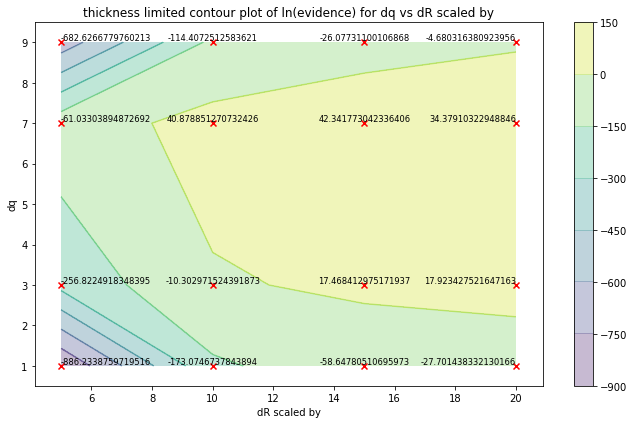

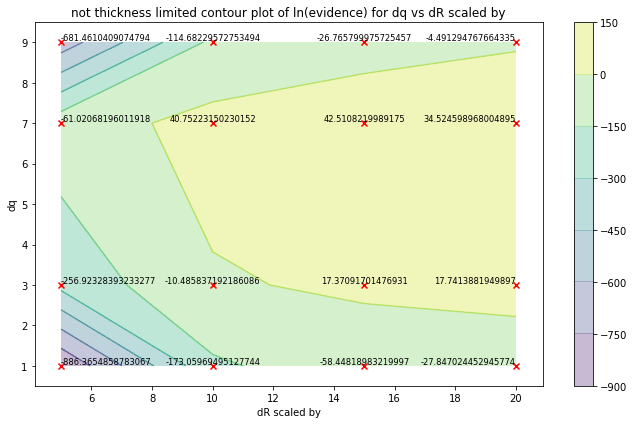

Wall time: 628 ms


In [20]:
%%time

ha_s = ["left", "center", "center", "right"]

print("thickness limited ln(Evidence):",lnEvidence1)
print("not thickness limited ln(Evidence):",lnEvidence2)

zs= np.array(lnEvidence1).reshape(len(resolutions), len(dRScaleBys)).transpose()
plt.figure(figI)
figI+=1
plt.contour(dRScaleBys,resolutions,zs,alpha=0.5);
plt.contourf(dRScaleBys,resolutions,zs,alpha=0.3);
plt.colorbar();
for i in range(len(dRScaleBys)):
    for j in range(len(resolutions)):
        plt.scatter(dRScaleBys[i],resolutions[j],c="red",marker="x");
        ha = ha_s[i]
        plt.annotate(zs[j][i],(dRScaleBys[i],resolutions[j]),
                    horizontalalignment=ha, fontsize="small", verticalalignment='bottom')
# for x in dRScaleBys:
#     for y in resolutions:
#         plt.scatter(x,y,c="red",marker="x");
plt.ylabel("dq");
plt.xlabel("dR scaled by");
plt.title("thickness limited contour plot of ln(evidence) for dq vs dR scaled by");
plt.tight_layout();
plt.show();
#--------

zs= np.array(lnEvidence2).reshape(len(resolutions), len(dRScaleBys)).transpose()
plt.figure(figI)
figI+=1
plt.contour(dRScaleBys,resolutions,zs,alpha=0.5);
plt.contourf(dRScaleBys,resolutions,zs,alpha=0.3);
plt.colorbar();
for i in range(len(dRScaleBys)):
    for j in range(len(resolutions)):
        plt.scatter(dRScaleBys[i],resolutions[j],c="red",marker="x");
        ha = ha_s[i]
        plt.annotate(zs[j][i],(dRScaleBys[i],resolutions[j]),
                    horizontalalignment=ha, fontsize="small", verticalalignment='bottom')
# for x in dRScaleBys:
#     for y in resolutions:
#         plt.scatter(x,y,c="red",marker="x");
plt.ylabel("dq");
plt.xlabel("dR scaled by");
plt.title("not thickness limited contour plot of ln(evidence) for dq vs dR scaled by");
plt.tight_layout();
plt.show();

thickness limited ln(Evidence): [-886.2338759719516, -256.8224918348395, -61.03303894872692, -682.6266779760213, -173.0746737843894, -10.302971524391873, 40.878851270732426, -114.4072512583621, -58.64780510695973, 17.468412975171937, 42.341773042336406, -26.07731100106868, -27.701438332130166, 17.923427521647163, 34.37910322948846, -4.680316380923956]
not thickness limited ln(Evidence): [-886.3654858783067, -256.92328393233277, -61.02068196011918, -681.4610409074794, -173.05969495127744, -10.485837192186086, 40.75223150230152, -114.68229572753494, -58.44818983219997, 17.37091701476931, 42.5108219989175, -26.765799975725457, -27.847024452945774, 17.7413881949897, 34.524598968004895, -4.491294767664335]

In [ ]:
# for objective1,objective2 in zip(objectives1,objectives2):
#     plt.figure(figI)
#     figI+=1

#     plt.subplot(2,2,1).set_title("data plotted for limited max thickness")
#     fig, ax = objective1.plot()
#     plt.subplot(2,2,2).set_title("structure plotted for limited max thickness")
#     plt.plot(*objective1.model.structure.sld_profile())
#     plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
#     plt.xlabel('distance / $\AA$');

#     plt.subplot(2,2,3).set_title("data plotted for limited max thickness")
#     fig, ax = objective2.plot()
#     plt.subplot(2,2,4).set_title("structure plotted for limited max thickness")
#     plt.plot(*objective2.model.structure.sld_profile())
#     plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
#     plt.xlabel('distance / $\AA$');
